Import Libraries

In [55]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [56]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


Load and preprocess the MNIST dataset

In [57]:
# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to the range [-1, 1]
train_images = train_images.astype("float32") / 255.0
train_images = (train_images - 0.5) / 0.5

# Reshape the images to include the channel dimension (28x28x1)
train_images = np.expand_dims(train_images, axis=-1)

In [58]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [59]:
# Create a TensorFlow dataset
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

Generator

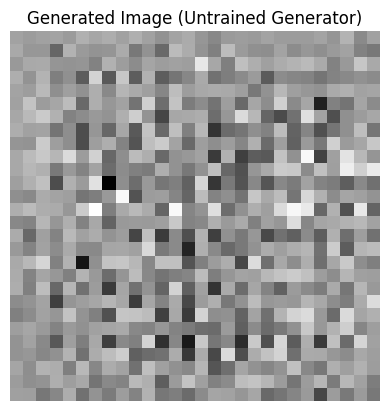

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_15 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 7, 7, 128)        

In [60]:
# Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ])
    return model

generator = build_generator()

# Generate a random noise vector
noise = tf.random.normal([1, 100])

# Generate an image using the generator
generated_image = generator(noise, training=False)

# Plot the generated image
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.title("Generated Image (Untrained Generator)")
plt.axis("off")
plt.show()

# Print the Generator summary
generator.summary()


In [61]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_15 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 7, 7, 128)        

Discriminator

In [62]:
# Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.GaussianNoise(0.1),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

# Test the Discriminator with a sample input
decision = discriminator(generated_image, training=False)

# Print the discriminator's decision on the generated image
print("Discriminator's decision on generated image:", decision.numpy())

# Print the Discriminator summary
discriminator.summary()

Discriminator's decision on generated image: [[-0.00102893]]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (Gaussian  (1, 28, 28, 1)            0         
 Noise)                                                          
                                                                 
 conv2d_8 (Conv2D)           (1, 14, 14, 64)           1664      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (1, 14, 14, 64)           0         
                                                                 
 dropout_8 (Dropout)         (1, 14, 14, 64)           0         
                                                                 
 conv2d_9 (Conv2D)           (1, 7, 7, 128)            204928    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (1, 7, 7, 128)            0  

In [63]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (Gaussian  (1, 28, 28, 1)            0         
 Noise)                                                          
                                                                 
 conv2d_8 (Conv2D)           (1, 14, 14, 64)           1664      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (1, 14, 14, 64)           0         
                                                                 
 dropout_8 (Dropout)         (1, 14, 14, 64)           0         
                                                                 
 conv2d_9 (Conv2D)           (1, 7, 7, 128)            204928    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (1, 7, 7, 128)            0         
                                                     

Loss Functions and Optimizers

In [64]:
# Define Binary Crossentropy as the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


Training Loop

In [65]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [66]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generate and visualize a batch of images after each epoch
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap="gray")
            plt.axis("off")
        plt.suptitle(f"Generated Images at Epoch {epoch + 1}")
        plt.show()

        print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")


Training started...
Epoch 1/50


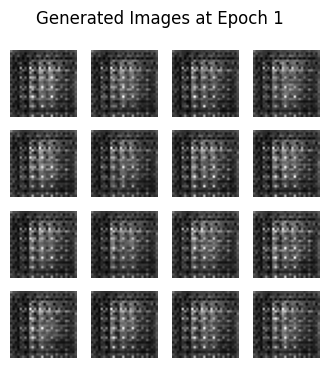

Generator Loss: 0.7345, Discriminator Loss: 1.1949
Epoch 2/50


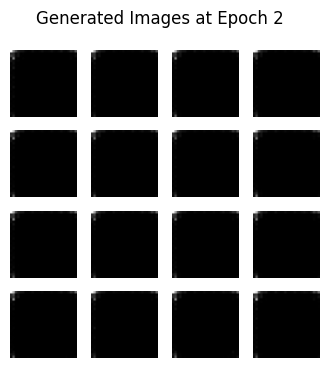

Generator Loss: 0.5796, Discriminator Loss: 1.6311
Epoch 3/50


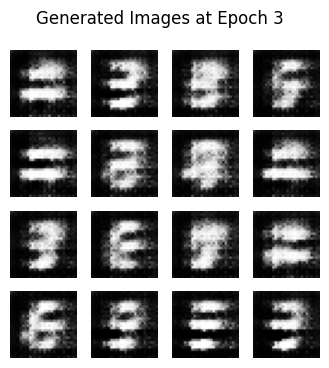

Generator Loss: 0.7163, Discriminator Loss: 1.3077
Epoch 4/50


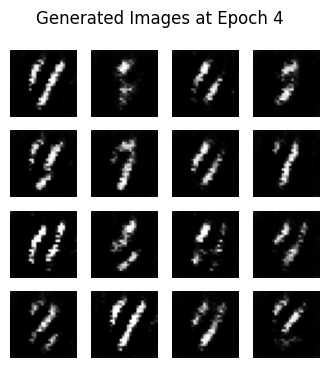

Generator Loss: 0.7515, Discriminator Loss: 1.3776
Epoch 5/50


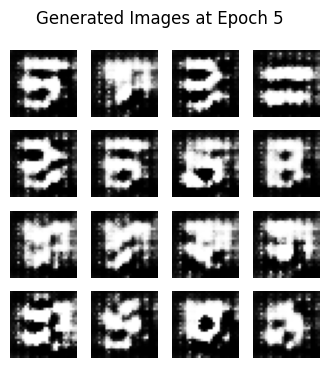

Generator Loss: 0.6227, Discriminator Loss: 1.3925
Epoch 6/50


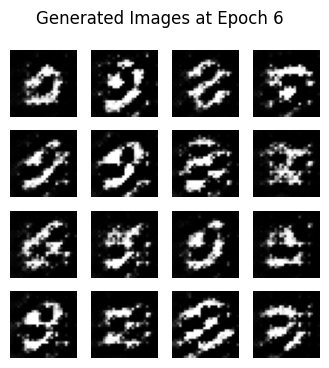

Generator Loss: 0.7531, Discriminator Loss: 1.2873
Epoch 7/50


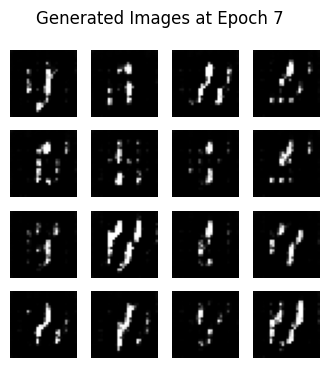

Generator Loss: 0.7689, Discriminator Loss: 1.2923
Epoch 8/50


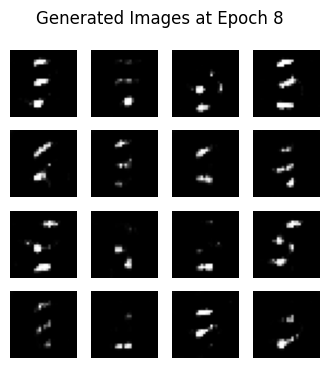

Generator Loss: 0.8154, Discriminator Loss: 1.3810
Epoch 9/50


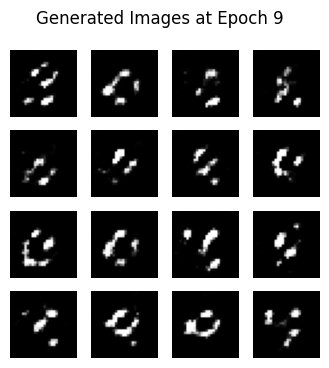

Generator Loss: 0.8335, Discriminator Loss: 1.2191
Epoch 10/50


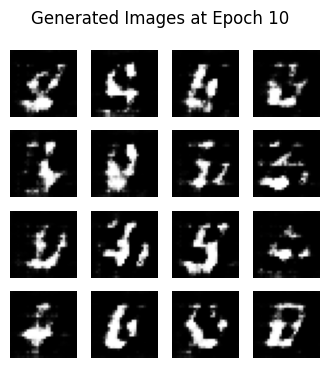

Generator Loss: 0.7081, Discriminator Loss: 1.3871
Epoch 11/50


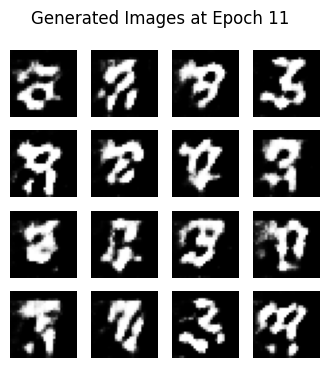

Generator Loss: 0.7119, Discriminator Loss: 1.3013
Epoch 12/50


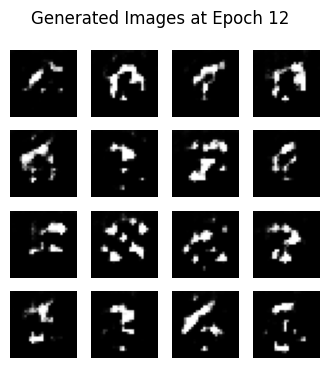

Generator Loss: 0.8151, Discriminator Loss: 1.3211
Epoch 13/50


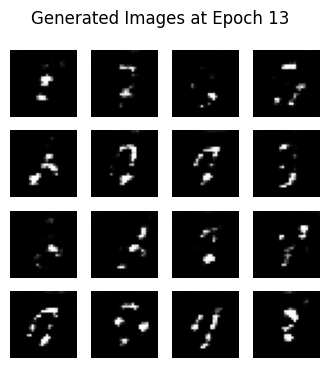

Generator Loss: 0.8571, Discriminator Loss: 1.2488
Epoch 14/50


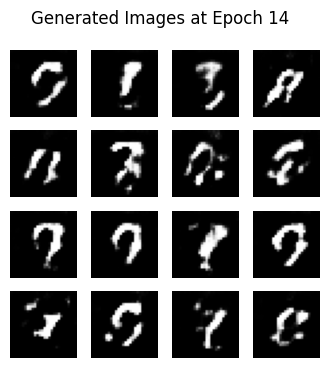

Generator Loss: 0.7336, Discriminator Loss: 1.4230
Epoch 15/50


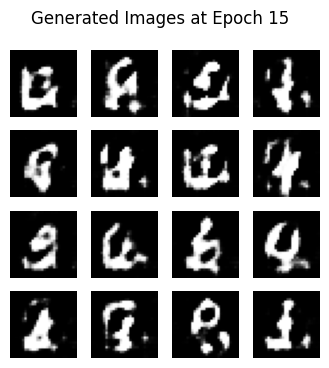

Generator Loss: 0.7318, Discriminator Loss: 1.3113
Epoch 16/50


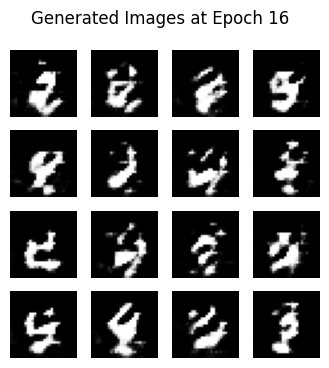

Generator Loss: 0.7567, Discriminator Loss: 1.2952
Epoch 17/50


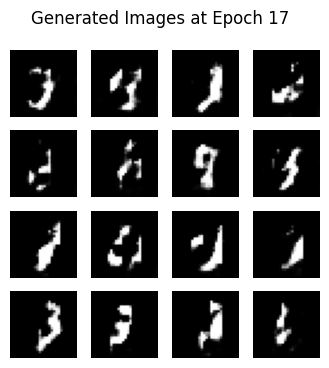

Generator Loss: 0.9539, Discriminator Loss: 1.1239
Epoch 18/50


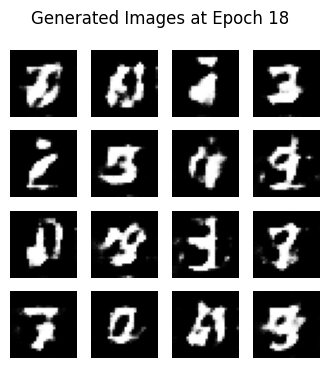

Generator Loss: 0.8953, Discriminator Loss: 1.2248
Epoch 19/50


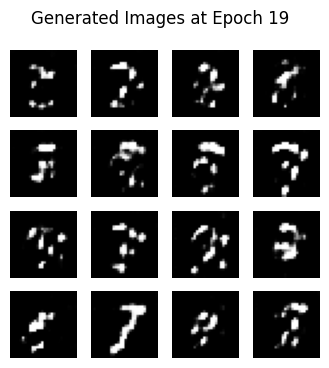

Generator Loss: 0.8766, Discriminator Loss: 1.2371
Epoch 20/50


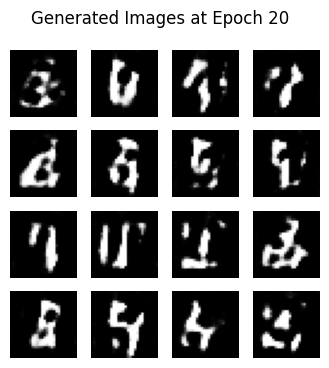

Generator Loss: 0.9253, Discriminator Loss: 1.1242
Epoch 21/50


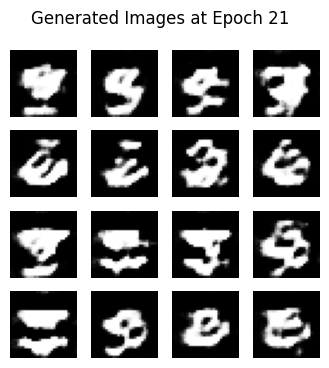

Generator Loss: 0.9341, Discriminator Loss: 1.0395
Epoch 22/50


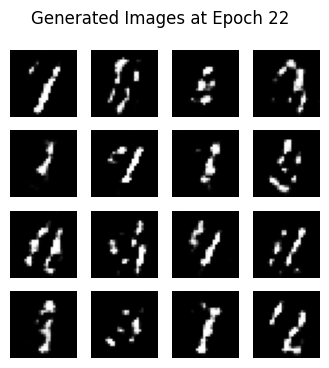

Generator Loss: 0.9695, Discriminator Loss: 1.1177
Epoch 23/50


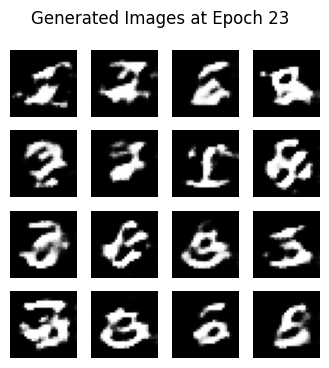

Generator Loss: 1.0068, Discriminator Loss: 1.1069
Epoch 24/50


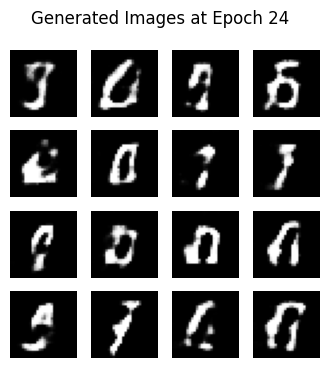

Generator Loss: 0.8430, Discriminator Loss: 1.4058
Epoch 25/50


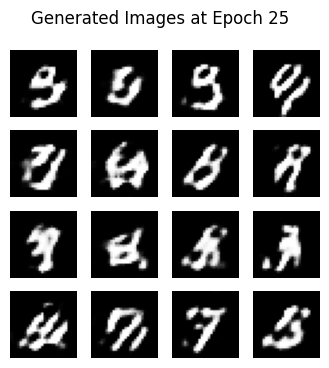

Generator Loss: 1.0409, Discriminator Loss: 1.0157
Epoch 26/50


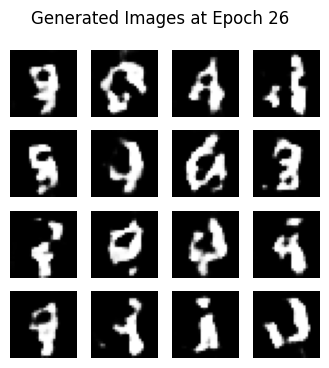

Generator Loss: 0.9963, Discriminator Loss: 1.0043
Epoch 27/50


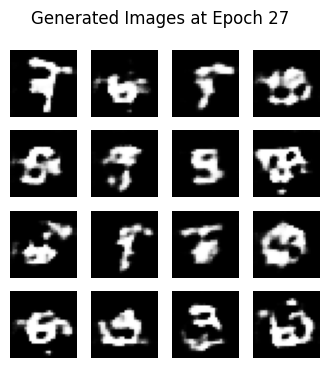

Generator Loss: 0.8671, Discriminator Loss: 1.2968
Epoch 28/50


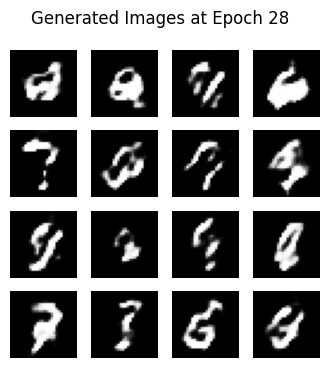

Generator Loss: 0.9930, Discriminator Loss: 1.2241
Epoch 29/50


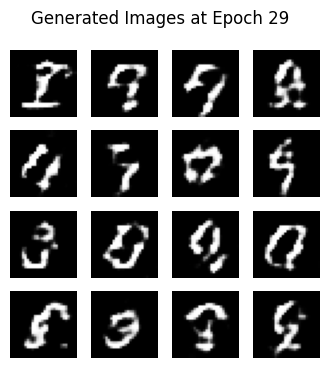

Generator Loss: 0.9048, Discriminator Loss: 1.2750
Epoch 30/50


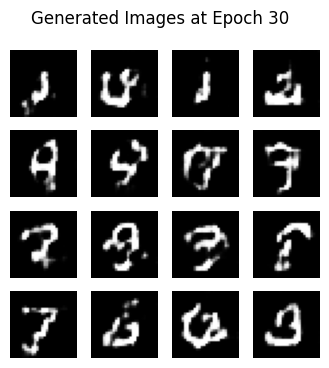

Generator Loss: 1.0181, Discriminator Loss: 1.2121
Epoch 31/50


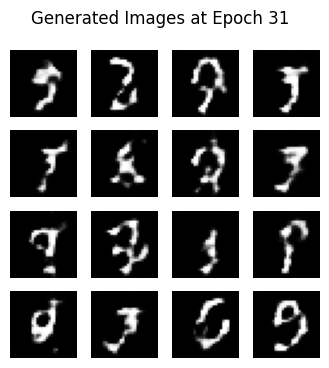

Generator Loss: 1.1129, Discriminator Loss: 1.1166
Epoch 32/50


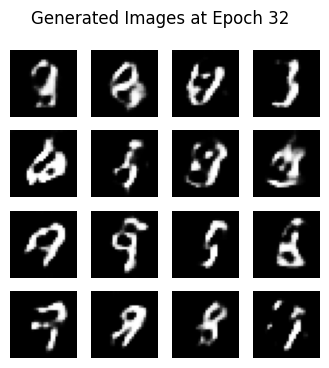

Generator Loss: 0.9377, Discriminator Loss: 1.2413
Epoch 33/50


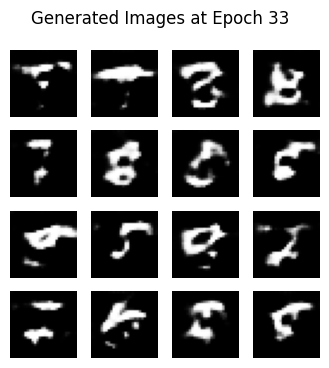

Generator Loss: 1.0611, Discriminator Loss: 1.0381
Epoch 34/50


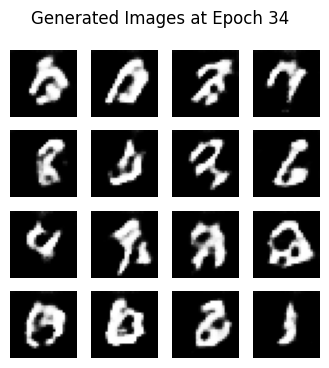

Generator Loss: 1.2097, Discriminator Loss: 0.9827
Epoch 35/50


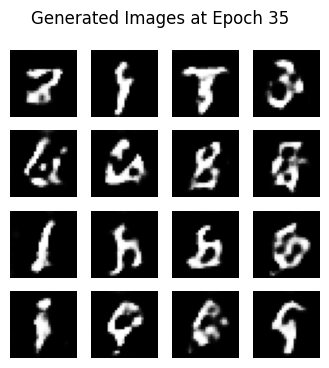

Generator Loss: 1.0619, Discriminator Loss: 1.0853
Epoch 36/50


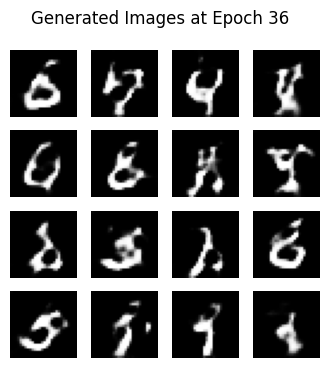

Generator Loss: 1.0609, Discriminator Loss: 1.0853
Epoch 37/50


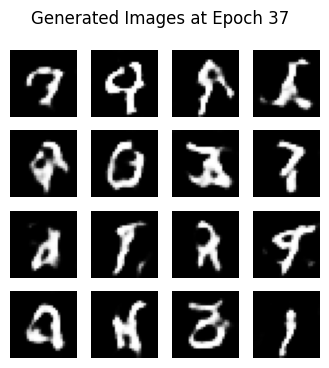

Generator Loss: 0.9314, Discriminator Loss: 1.3253
Epoch 38/50


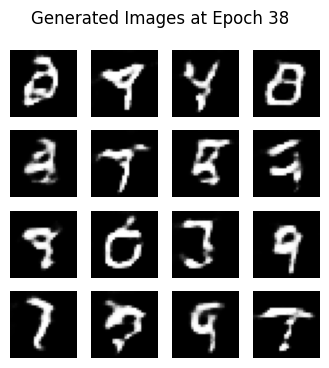

Generator Loss: 1.0088, Discriminator Loss: 1.0907
Epoch 39/50


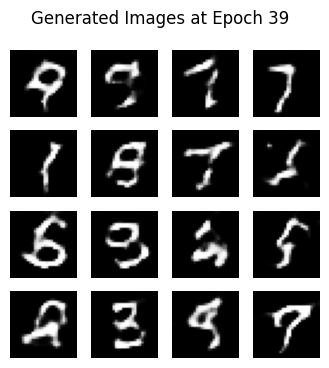

Generator Loss: 1.0005, Discriminator Loss: 1.1872
Epoch 40/50


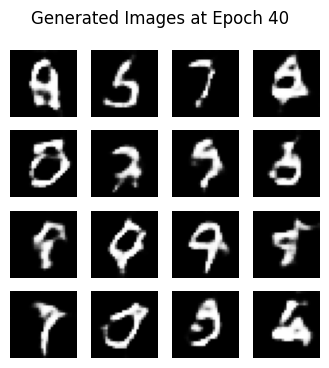

Generator Loss: 0.8473, Discriminator Loss: 1.2807
Epoch 41/50


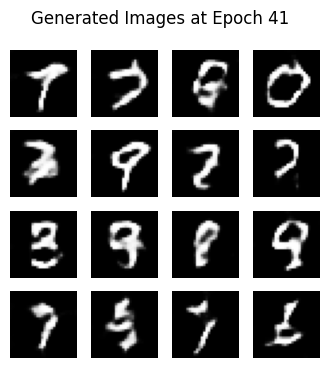

Generator Loss: 0.8729, Discriminator Loss: 1.2368
Epoch 42/50


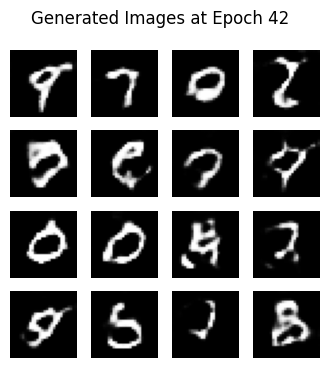

Generator Loss: 0.8205, Discriminator Loss: 1.4606
Epoch 43/50


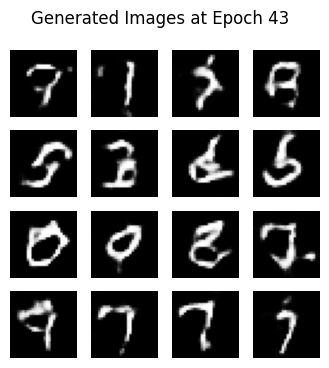

Generator Loss: 0.8711, Discriminator Loss: 1.2803
Epoch 44/50


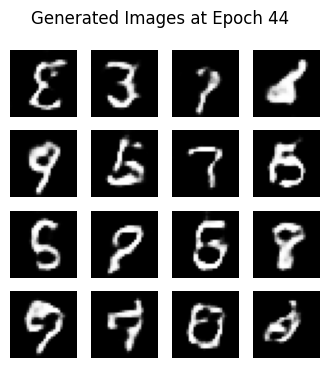

Generator Loss: 0.9665, Discriminator Loss: 1.2008
Epoch 45/50


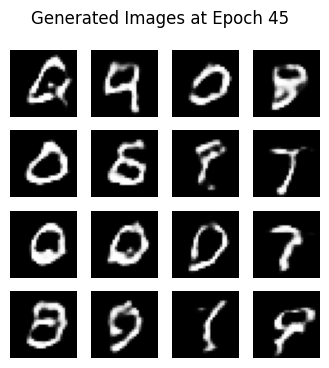

Generator Loss: 0.8750, Discriminator Loss: 1.3068
Epoch 46/50


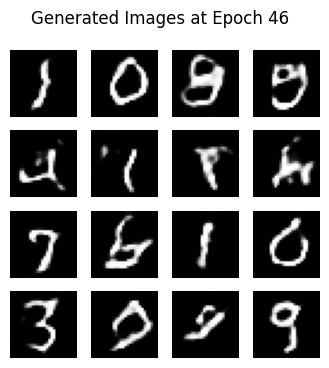

Generator Loss: 0.8826, Discriminator Loss: 1.2465
Epoch 47/50


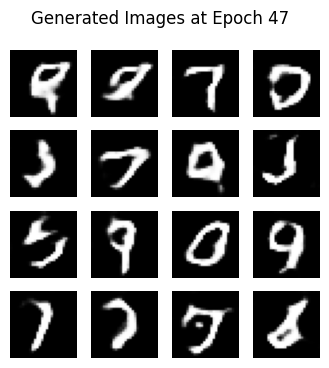

Generator Loss: 0.7607, Discriminator Loss: 1.4320
Epoch 48/50


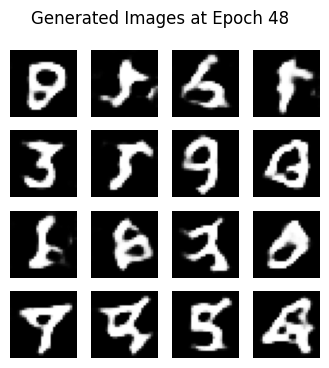

Generator Loss: 0.9786, Discriminator Loss: 1.0794
Epoch 49/50


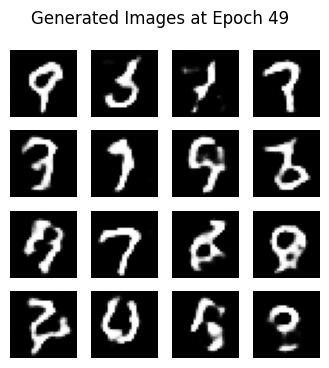

Generator Loss: 0.7419, Discriminator Loss: 1.4187
Epoch 50/50


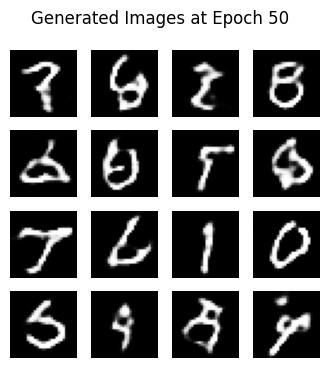

Generator Loss: 0.8970, Discriminator Loss: 1.3477
Training completed!


In [67]:
# Set the number of epochs
EPOCHS = 50

# Train the GAN
print("Training started...")
train(train_dataset, EPOCHS)
print("Training completed!")


In [68]:
# Save the Generator model
generator.save("generator_model_1.h5")
print("Generator model saved as 'generator_model.h5'")

# Save the Discriminator model
discriminator.save("discriminator_model_1.h5")
print("Discriminator model saved as 'discriminator_model.h5'")

Generator model saved as 'generator_model.h5'
Discriminator model saved as 'discriminator_model.h5'


c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
gen_losses = [
    0.7345, 0.5796, 0.7163, 0.7515, 0.6227, 0.7531, 0.7689, 0.8154,
    0.8335, 0.7081, 0.7119, 0.8151, 0.8571, 0.7336, 0.7318, 0.7567,
    0.9539, 0.8953, 0.8766, 0.9253, 0.9341, 0.9695, 1.0068, 0.8430,
    1.0409, 0.9963, 0.8671, 0.9930, 0.9048, 1.0181, 1.1129, 0.9377,
    1.0611, 1.2097, 1.0619, 1.0609, 0.9314, 1.0088, 1.0005, 0.8473,
    0.8729, 0.8205, 0.8711, 0.9665, 0.8750, 0.8826, 0.7607, 0.9786,
    0.7419, 0.8970
]

disc_losses = [
    1.1949, 1.6311, 1.3077, 1.3776, 1.3925, 1.2873, 1.2923, 1.3810,
    1.2191, 1.3871, 1.3013, 1.3211, 1.2488, 1.4230, 1.3113, 1.2952,
    1.1239, 1.2248, 1.2371, 1.1242, 1.0395, 1.1177, 1.1069, 1.4058,
    1.0157, 1.0043, 1.2968, 1.2241, 1.2750, 1.2121, 1.1166, 1.2413,
    1.0381, 0.9827, 1.0853, 1.0853, 1.3253, 1.0907, 1.1872, 1.2807,
    1.2368, 1.4606, 1.2803, 1.2008, 1.3068, 1.2465, 1.4320, 1.0794,
    1.4187, 1.3477
]


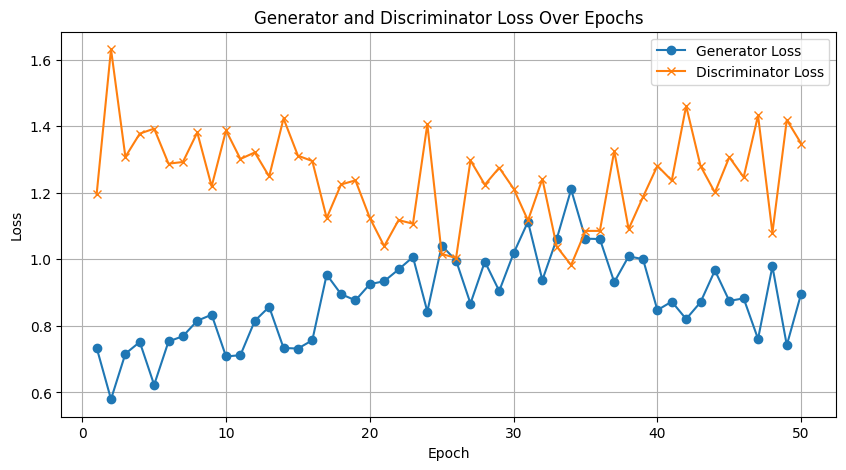

In [72]:
# Plot Generator and Discriminator Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss", marker='o')
plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss", marker='x')
plt.title("Generator and Discriminator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


Testing

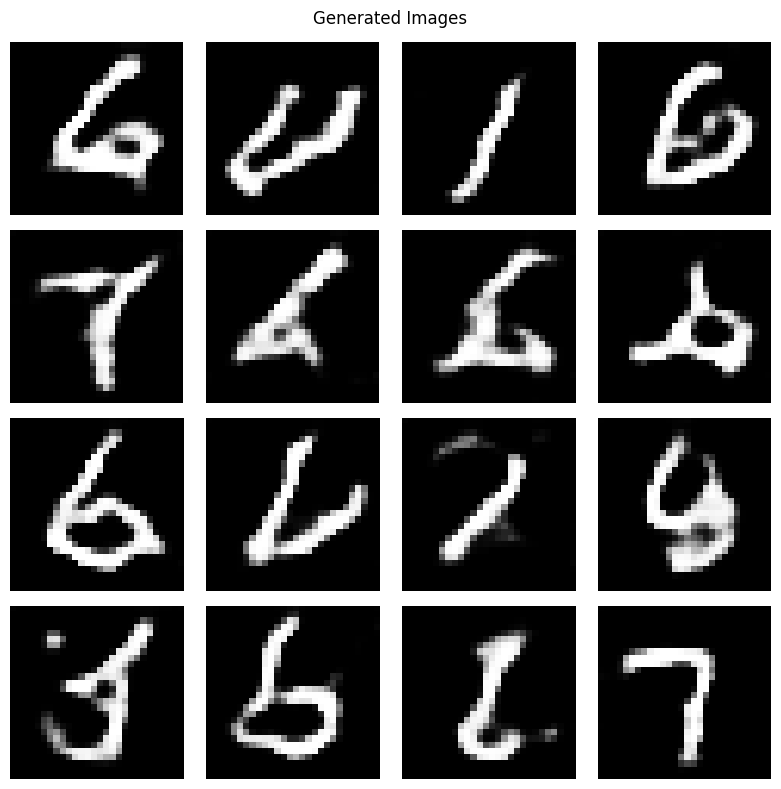

In [73]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved Generator model
generator = tf.keras.models.load_model("generator_model_1.h5")

# Generate random noise
num_images = 16  # Number of images to generate
noise = tf.random.normal([num_images, 100])  # Same noise dimension used during training

# Generate images using the Generator
generated_images = generator(noise, training=False)

# Plot the generated images
plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap="gray")  # Rescale from [-1, 1] to [0, 1]
    plt.axis("off")
plt.suptitle("Generated Images")
plt.tight_layout()
plt.show()


In [74]:
# Load the saved Discriminator model
discriminator = tf.keras.models.load_model("discriminator_model_1.h5")

# Test with real images
(real_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
real_images = real_images[:16]  # Take a small batch of real images
real_images = real_images.astype("float32") / 255.0
real_images = (real_images - 0.5) / 0.5  # Normalize to [-1, 1]
real_images = tf.expand_dims(real_images, axis=-1)

# Test with generated images
fake_images = generator(tf.random.normal([16, 100]), training=False)

# Get Discriminator predictions
real_predictions = discriminator(real_images, training=False)
fake_predictions = discriminator(fake_images, training=False)

# Display results
print("Discriminator predictions for real images:", real_predictions.numpy())
print("Discriminator predictions for fake images:", fake_predictions.numpy())


Discriminator predictions for real images: [[ 0.8414788 ]
 [ 1.5711045 ]
 [ 0.37687486]
 [ 0.5973706 ]
 [ 0.5932099 ]
 [ 1.3301159 ]
 [ 0.1620711 ]
 [ 1.0190917 ]
 [-0.6944103 ]
 [ 0.8120285 ]
 [ 0.6491642 ]
 [ 0.7726301 ]
 [ 1.1241915 ]
 [ 1.7306964 ]
 [-0.1116353 ]
 [ 0.55130553]]
Discriminator predictions for fake images: [[-0.6124586 ]
 [ 0.19073   ]
 [ 0.23475629]
 [ 0.3586945 ]
 [ 1.0052065 ]
 [ 1.2309726 ]
 [ 0.373071  ]
 [ 0.36467838]
 [-0.8947046 ]
 [ 0.37414533]
 [ 0.04811253]
 [ 0.32384866]
 [-0.06203526]
 [ 0.30438817]
 [ 0.12573138]
 [ 0.72755873]]


In [75]:
for i, img in enumerate(generated_images):
    plt.imsave(f"generated_image_{i}.png", img[:, :, 0] * 0.5 + 0.5, cmap="gray")


In [78]:
import tensorflow as tf

# Load the previously trained Generator and Discriminator models
generator = tf.keras.models.load_model("generator_model_1.h5")
discriminator = tf.keras.models.load_model("discriminator_model_1.h5")


In [79]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Reinitialize the optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Prepare the dataset (if needed)
BUFFER_SIZE = 60000
BATCH_SIZE = 256
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_images = tf.expand_dims(train_images, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Epoch 51/100


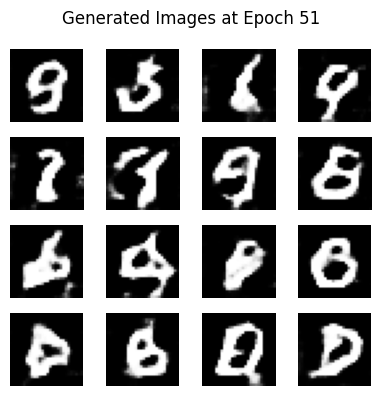

Generator Loss: 0.8435, Discriminator Loss: 1.1751
Epoch 52/100


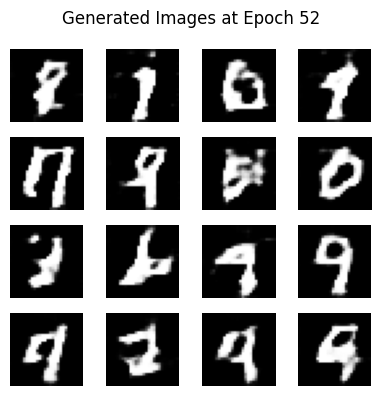

Generator Loss: 1.1920, Discriminator Loss: 0.8355
Epoch 53/100


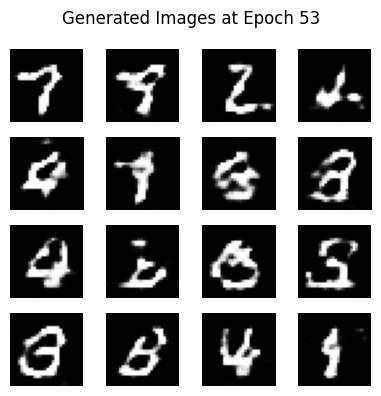

Generator Loss: 0.7847, Discriminator Loss: 1.4345
Epoch 54/100


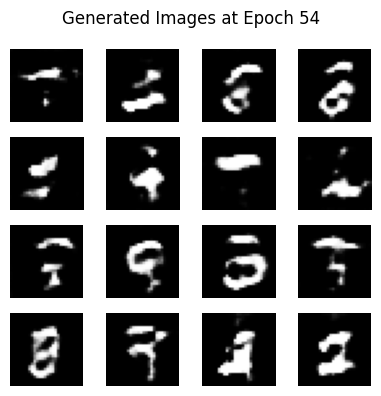

Generator Loss: 1.3203, Discriminator Loss: 1.0957
Epoch 55/100


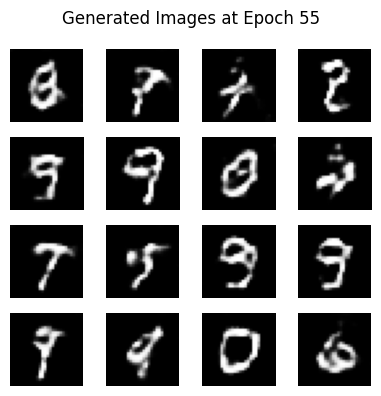

Generator Loss: 0.8952, Discriminator Loss: 1.2903
Epoch 56/100


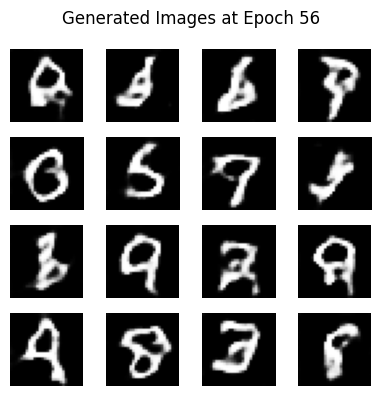

Generator Loss: 0.8941, Discriminator Loss: 1.1780
Epoch 57/100


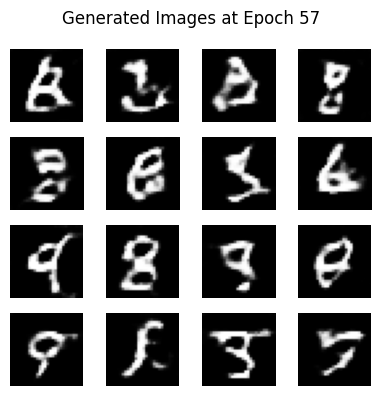

Generator Loss: 1.0013, Discriminator Loss: 1.3333
Epoch 58/100


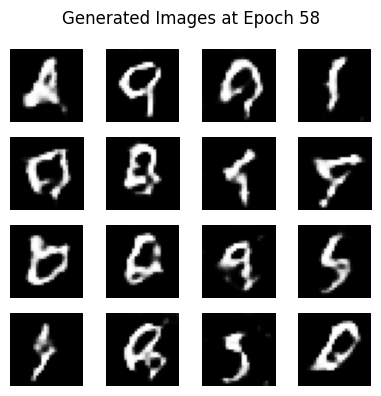

Generator Loss: 0.9356, Discriminator Loss: 1.2562
Epoch 59/100


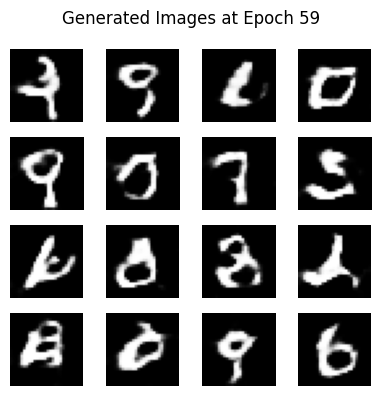

Generator Loss: 0.9226, Discriminator Loss: 1.2165
Epoch 60/100


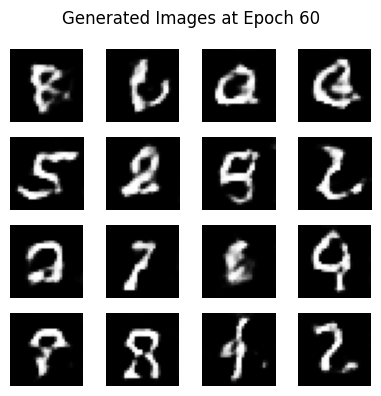

Generator Loss: 0.9829, Discriminator Loss: 1.1998
Epoch 61/100


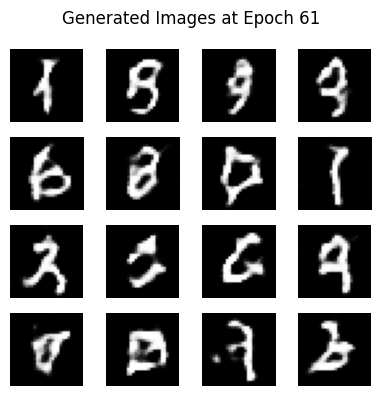

Generator Loss: 0.9437, Discriminator Loss: 1.2103
Epoch 62/100


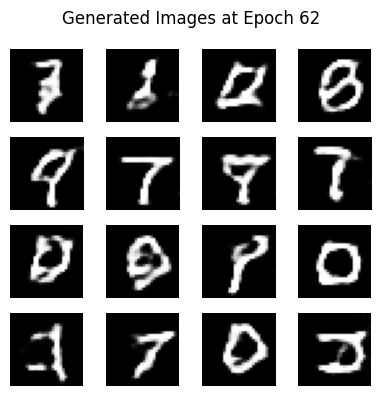

Generator Loss: 1.0405, Discriminator Loss: 1.0802
Epoch 63/100


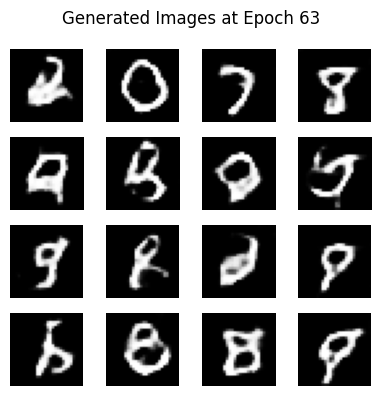

Generator Loss: 1.0194, Discriminator Loss: 1.2379
Epoch 64/100


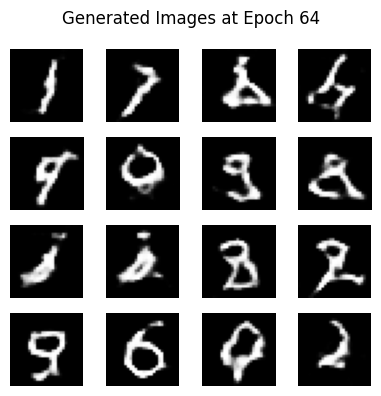

Generator Loss: 0.9566, Discriminator Loss: 1.3720
Epoch 65/100


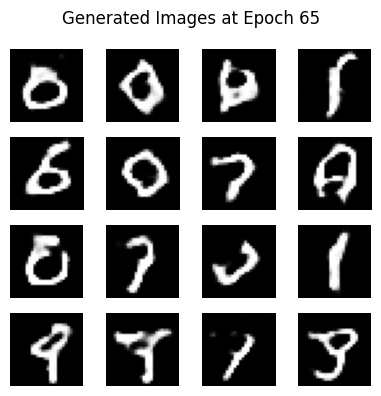

Generator Loss: 0.9581, Discriminator Loss: 1.2964
Epoch 66/100


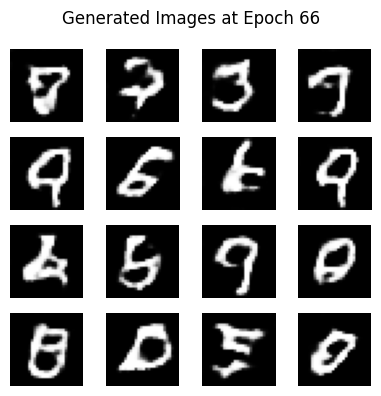

Generator Loss: 1.1293, Discriminator Loss: 0.8798
Epoch 67/100


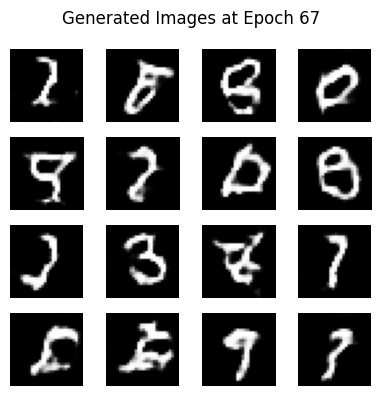

Generator Loss: 0.9664, Discriminator Loss: 1.1100
Epoch 68/100


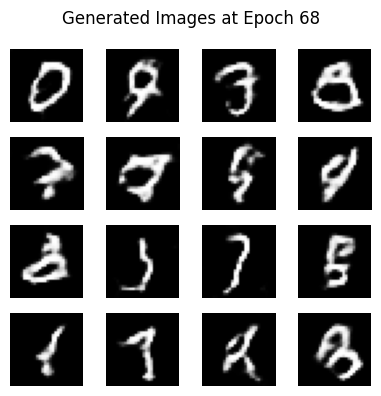

Generator Loss: 0.8965, Discriminator Loss: 1.2551
Epoch 69/100


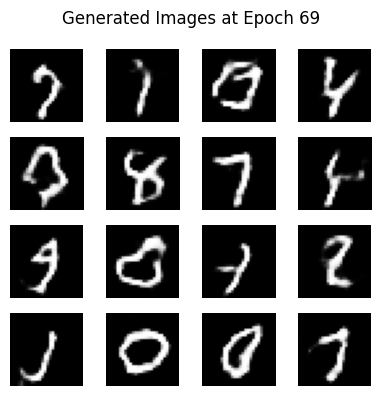

Generator Loss: 0.8368, Discriminator Loss: 1.1997
Epoch 70/100


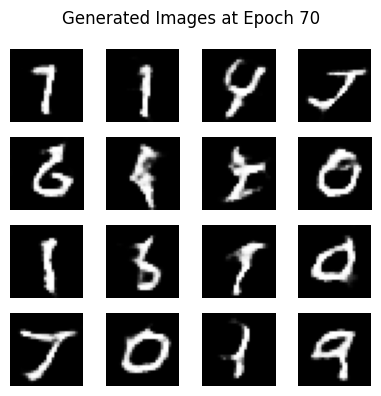

Generator Loss: 0.8298, Discriminator Loss: 1.2368
Epoch 71/100


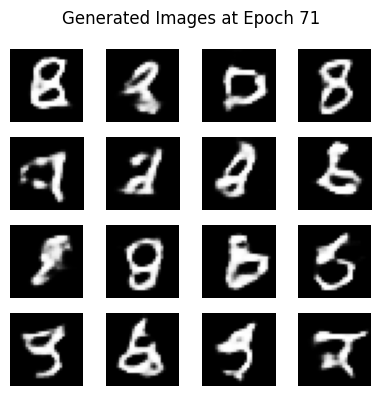

Generator Loss: 0.8852, Discriminator Loss: 1.3672
Epoch 72/100


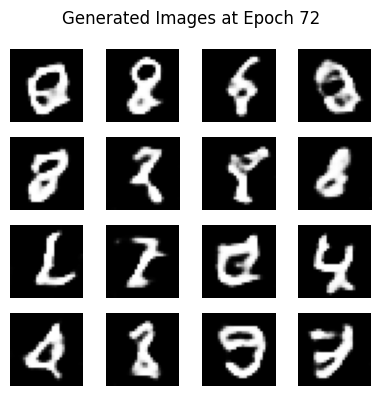

Generator Loss: 1.0131, Discriminator Loss: 1.1512
Epoch 73/100


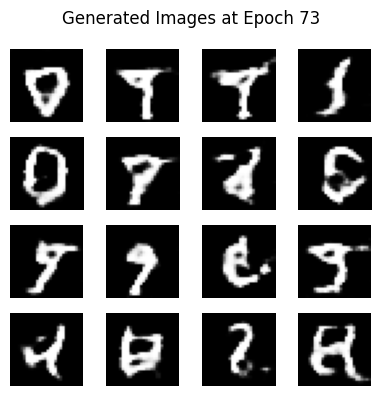

Generator Loss: 1.0607, Discriminator Loss: 1.1572
Epoch 74/100


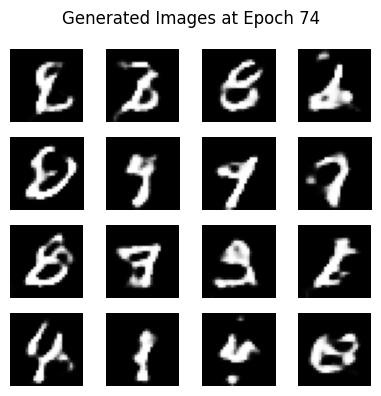

Generator Loss: 1.1615, Discriminator Loss: 1.1036
Epoch 75/100


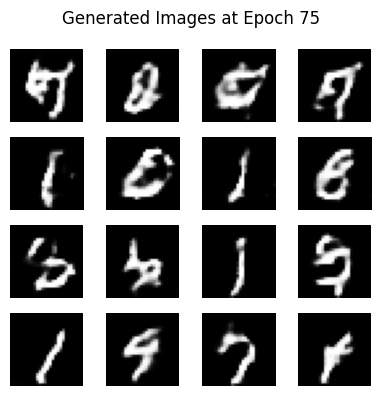

Generator Loss: 1.0585, Discriminator Loss: 1.2035
Epoch 76/100


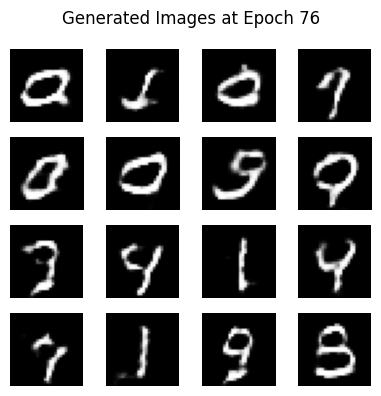

Generator Loss: 0.9663, Discriminator Loss: 1.2505
Epoch 77/100


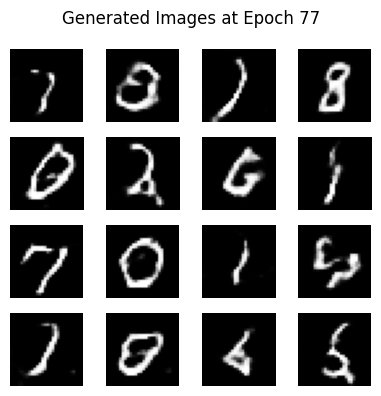

Generator Loss: 1.0234, Discriminator Loss: 1.0956
Epoch 78/100


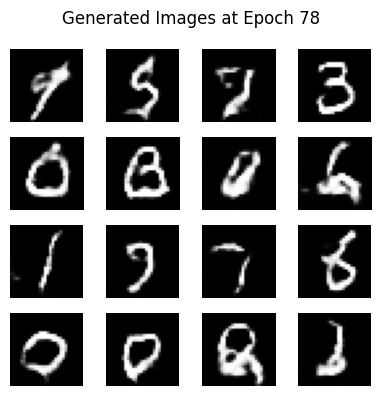

Generator Loss: 0.9604, Discriminator Loss: 1.1939
Epoch 79/100


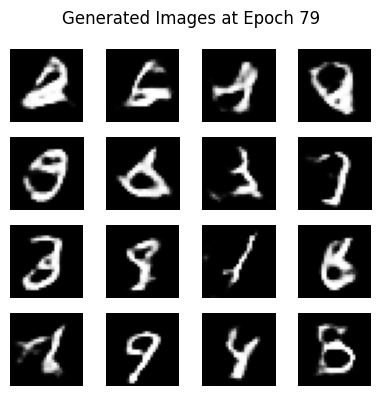

Generator Loss: 0.9316, Discriminator Loss: 1.3622
Epoch 80/100


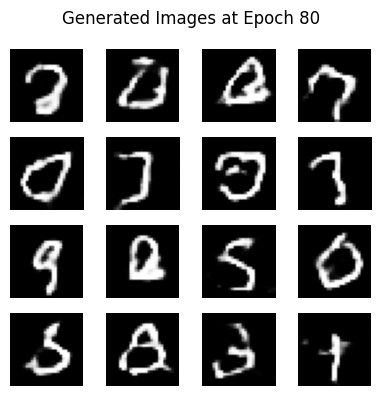

Generator Loss: 0.9018, Discriminator Loss: 1.3932
Epoch 81/100


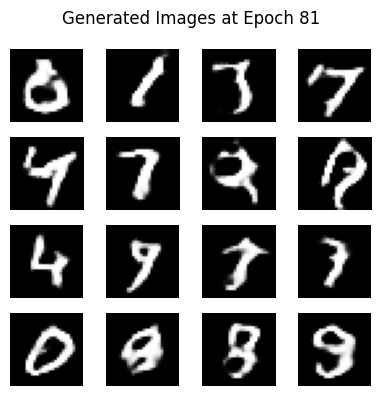

Generator Loss: 0.7971, Discriminator Loss: 1.5043
Epoch 82/100


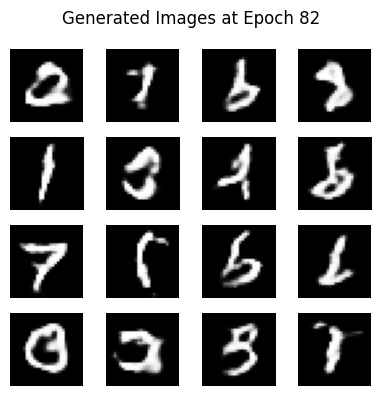

Generator Loss: 0.8702, Discriminator Loss: 1.2889
Epoch 83/100


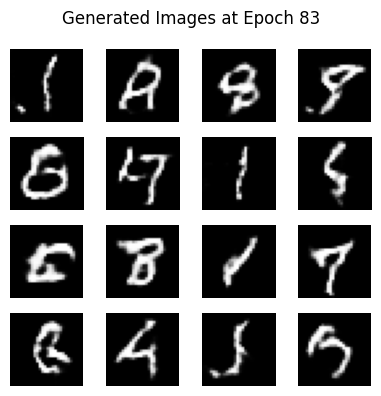

Generator Loss: 0.8564, Discriminator Loss: 1.2517
Epoch 84/100


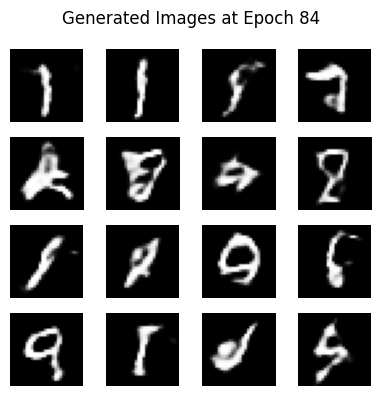

Generator Loss: 0.8230, Discriminator Loss: 1.3317
Epoch 85/100


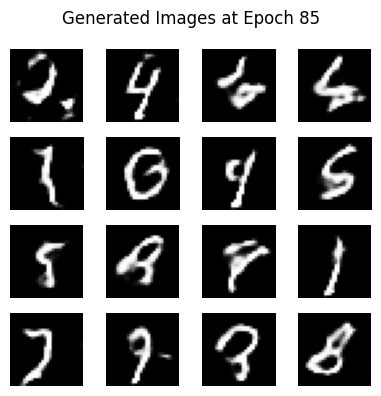

Generator Loss: 0.8921, Discriminator Loss: 1.3134
Epoch 86/100


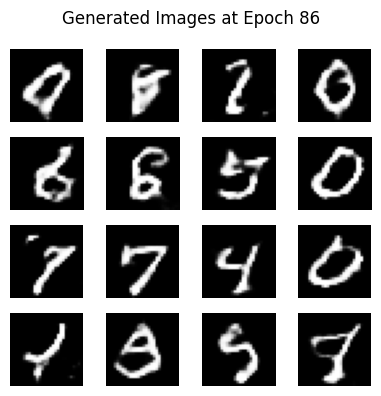

Generator Loss: 0.8718, Discriminator Loss: 1.3968
Epoch 87/100


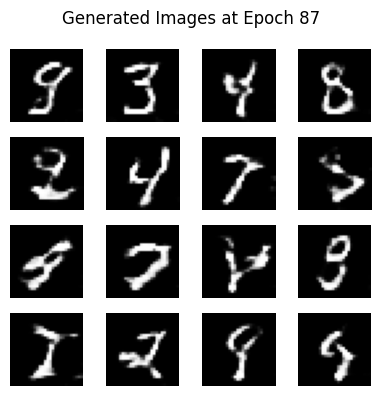

Generator Loss: 1.1189, Discriminator Loss: 1.1376
Epoch 88/100


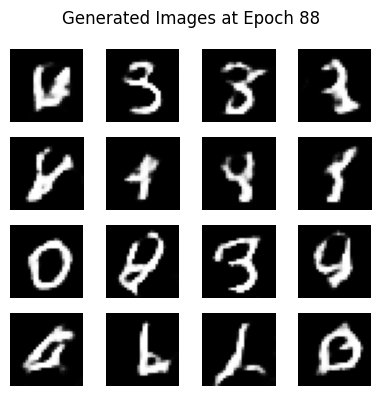

Generator Loss: 0.7741, Discriminator Loss: 1.5164
Epoch 89/100


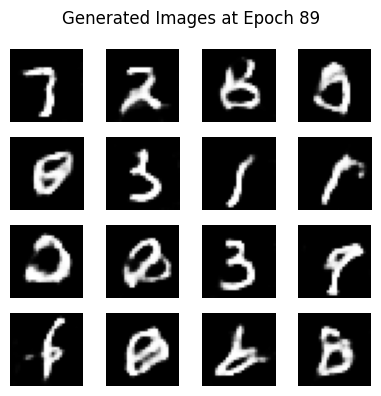

Generator Loss: 0.8261, Discriminator Loss: 1.4008
Epoch 90/100


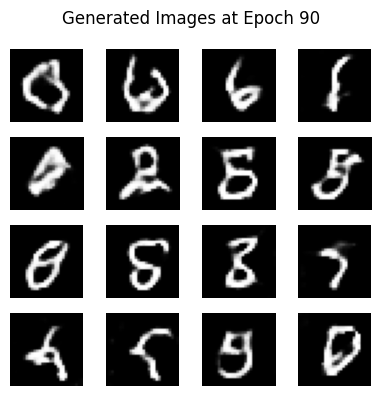

Generator Loss: 0.9851, Discriminator Loss: 1.2620
Epoch 91/100


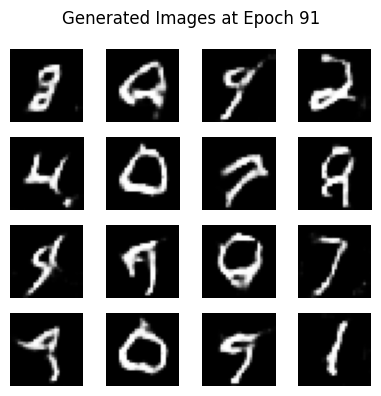

Generator Loss: 0.8814, Discriminator Loss: 1.2635
Epoch 92/100


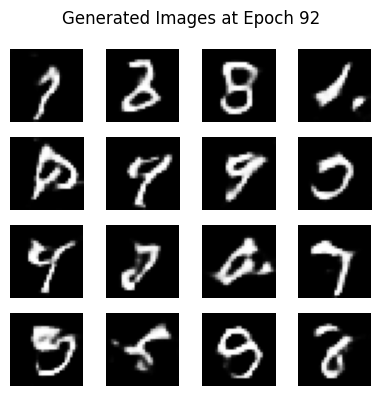

Generator Loss: 0.8831, Discriminator Loss: 1.2966
Epoch 93/100


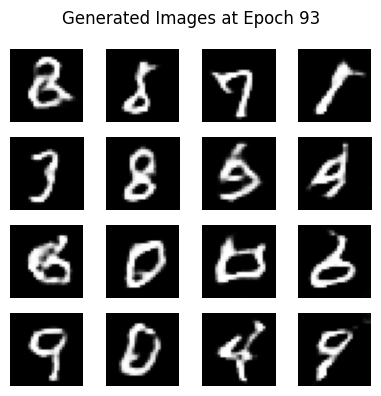

Generator Loss: 0.8670, Discriminator Loss: 1.2204
Epoch 94/100


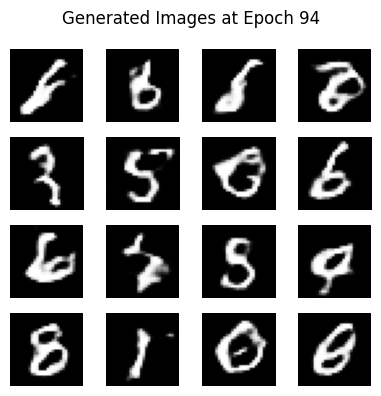

Generator Loss: 1.0013, Discriminator Loss: 1.1725
Epoch 95/100


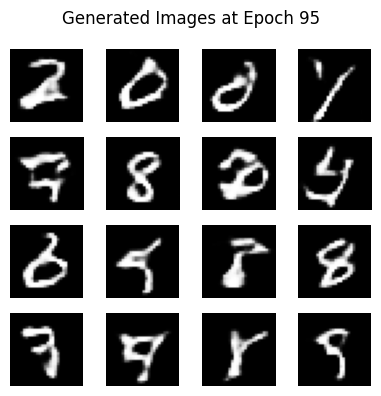

Generator Loss: 0.8860, Discriminator Loss: 1.2711
Epoch 96/100


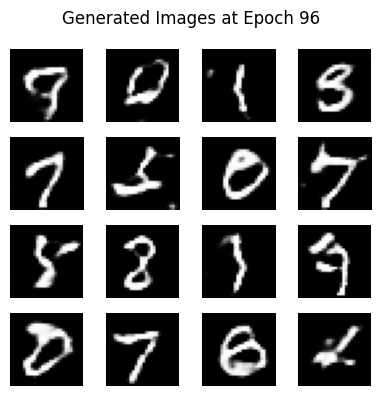

Generator Loss: 0.9260, Discriminator Loss: 1.3313
Epoch 97/100


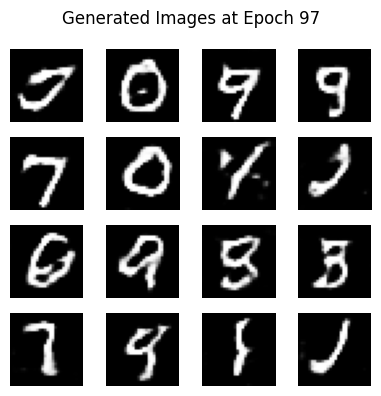

Generator Loss: 0.7653, Discriminator Loss: 1.3858
Epoch 98/100


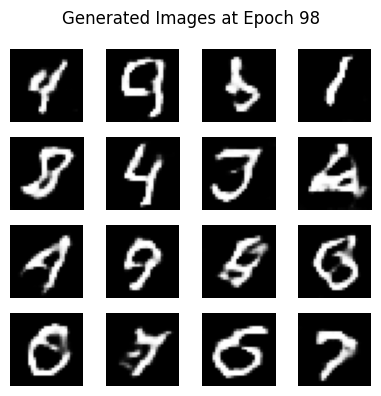

Generator Loss: 0.9154, Discriminator Loss: 1.2981
Epoch 99/100


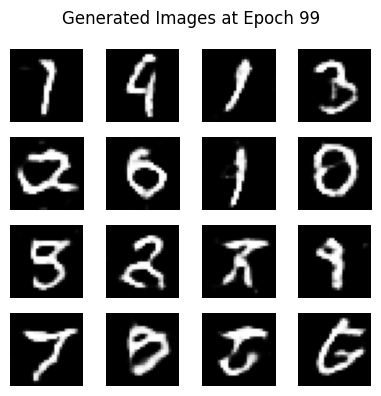

Generator Loss: 0.8906, Discriminator Loss: 1.2405
Epoch 100/100


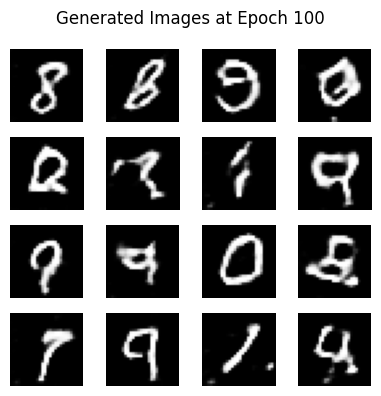

Generator Loss: 0.8463, Discriminator Loss: 1.4120


In [81]:
# Function to train one step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Continue training from epoch 51
start_epoch = 51
new_epochs = 50  # Additional epochs
gen_losses = []
disc_losses = []

for epoch in range(start_epoch, start_epoch + new_epochs):
    print(f"Epoch {epoch}/{start_epoch + new_epochs - 1}")
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    # Save the model periodically
    if epoch % 5 == 0:  # Save every 5 epochs
        generator.save(f"generator_model_{epoch}.h5")
        discriminator.save(f"discriminator_model_{epoch}.h5")
    
    # Visualize generated images
    noise = tf.random.normal([16, 100])
    generated_images = generator(noise, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.tight_layout()
    plt.show()

    print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")


In [83]:
generator.save("generator_model_final.h5")
discriminator.save("discriminator_model_final.h5")


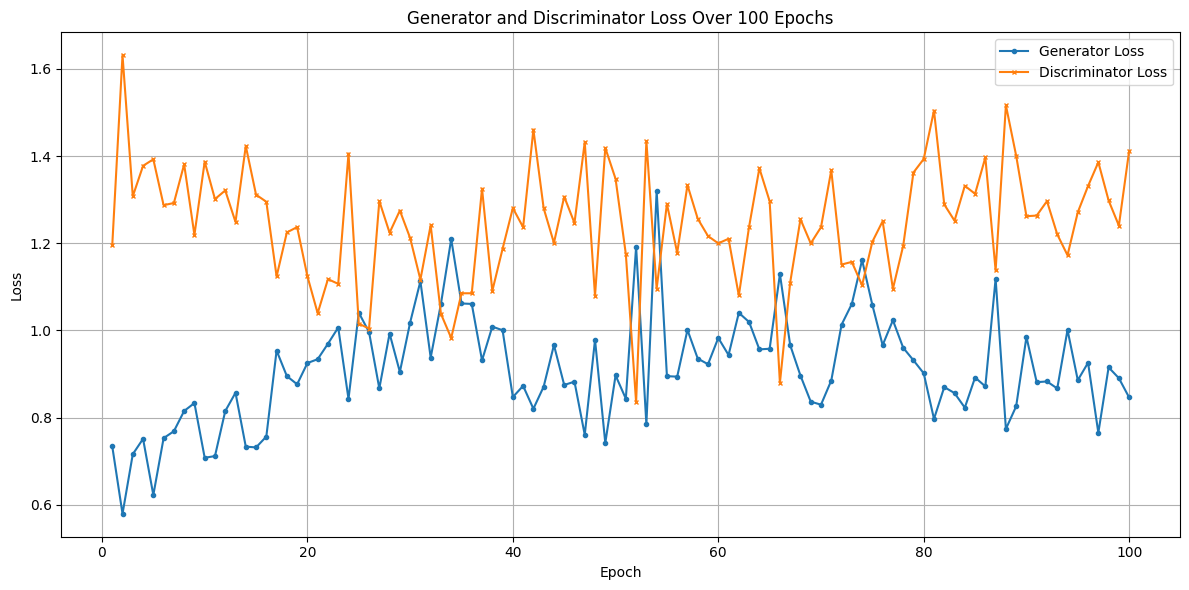

In [84]:
import matplotlib.pyplot as plt

# Loss values from the output logs for 100 epochs (including 50 initial and 50 additional epochs)
gen_losses = [
    0.7345, 0.5796, 0.7163, 0.7515, 0.6227, 0.7531, 0.7689, 0.8154, 0.8335, 0.7081,
    0.7119, 0.8151, 0.8571, 0.7336, 0.7318, 0.7567, 0.9539, 0.8953, 0.8766, 0.9253,
    0.9341, 0.9695, 1.0068, 0.8430, 1.0409, 0.9963, 0.8671, 0.9930, 0.9048, 1.0181,
    1.1129, 0.9377, 1.0611, 1.2097, 1.0619, 1.0609, 0.9314, 1.0088, 1.0005, 0.8473,
    0.8729, 0.8205, 0.8711, 0.9665, 0.8750, 0.8826, 0.7607, 0.9786, 0.7419, 0.8970,
    0.8435, 1.1920, 0.7847, 1.3203, 0.8952, 0.8941, 1.0013, 0.9356, 0.9226, 0.9829,
    0.9437, 1.0405, 1.0194, 0.9566, 0.9581, 1.1293, 0.9664, 0.8965, 0.8368, 0.8298,
    0.8852, 1.0131, 1.0607, 1.1615, 1.0585, 0.9663, 1.0234, 0.9604, 0.9316, 0.9018,
    0.7971, 0.8702, 0.8564, 0.8230, 0.8921, 0.8718, 1.1189, 0.7741, 0.8261, 0.9851,
    0.8814, 0.8831, 0.8670, 1.0013, 0.8860, 0.9260, 0.7653, 0.9154, 0.8906, 0.8463
]

disc_losses = [
    1.1949, 1.6311, 1.3077, 1.3776, 1.3925, 1.2873, 1.2923, 1.3810, 1.2191, 1.3871,
    1.3013, 1.3211, 1.2488, 1.4230, 1.3113, 1.2952, 1.1239, 1.2248, 1.2371, 1.1242,
    1.0395, 1.1177, 1.1069, 1.4058, 1.0157, 1.0043, 1.2968, 1.2241, 1.2750, 1.2121,
    1.1166, 1.2413, 1.0381, 0.9827, 1.0853, 1.0853, 1.3253, 1.0907, 1.1872, 1.2807,
    1.2368, 1.4606, 1.2803, 1.2008, 1.3068, 1.2465, 1.4320, 1.0794, 1.4187, 1.3477,
    1.1751, 0.8355, 1.4345, 1.0957, 1.2903, 1.1780, 1.3333, 1.2562, 1.2165, 1.1998,
    1.2103, 1.0802, 1.2379, 1.3720, 1.2964, 0.8798, 1.1100, 1.2551, 1.1997, 1.2368,
    1.3672, 1.1512, 1.1572, 1.1036, 1.2035, 1.2505, 1.0956, 1.1939, 1.3622, 1.3932,
    1.5043, 1.2889, 1.2517, 1.3317, 1.3134, 1.3968, 1.1376, 1.5164, 1.4008, 1.2620,
    1.2635, 1.2966, 1.2204, 1.1725, 1.2711, 1.3313, 1.3858, 1.2981, 1.2405, 1.4120
]

# Plotting the losses over 100 epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), gen_losses, label="Generator Loss", marker='o', markersize=3)
plt.plot(range(1, 101), disc_losses, label="Discriminator Loss", marker='x', markersize=3)
plt.title("Generator and Discriminator Loss Over 100 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


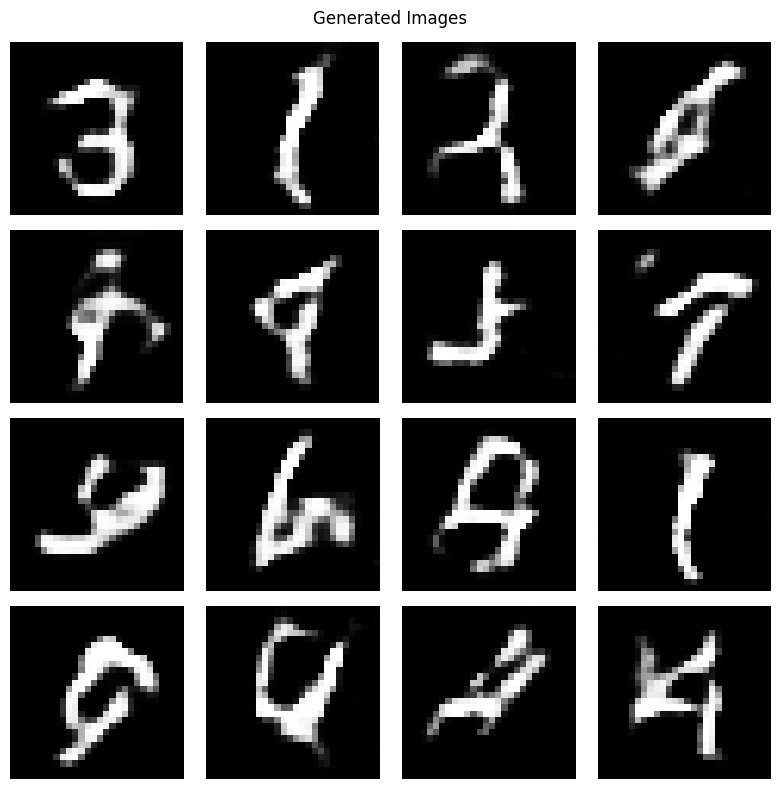

In [85]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved Generator model
generator = tf.keras.models.load_model("generator_model_1.h5")

# Generate random noise
num_images = 16  # Number of images to generate
noise = tf.random.normal([num_images, 100])  # Same noise dimension used during training

# Generate images using the Generator
generated_images = generator(noise, training=False)

# Plot the generated images
plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap="gray")  # Rescale from [-1, 1] to [0, 1]
    plt.axis("off")
plt.suptitle("Generated Images")
plt.tight_layout()
plt.show()
